<a href="https://colab.research.google.com/github/LuisRoberto96/Exercicios_Hadoop/blob/main/Exerc%C3%ADcios%20aula%204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Conhecendo os dados - Analise exploratória**
Objetivo:
Carregar, conhecer e explorar o dataser Olist

In [ ]:
# !pip install kagglehub pandas numpy matplotlib seaborn scikit-learn

import kagglehub
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Dependências importadas com sucesso!")


Dependências importadas com sucesso!


**Download e carregamento dos dados**

In [ ]:
#Download do dataset olistbr de ecommerce
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print(f"\n Dataset baixado em: {path}")

#Listar os arquivs CSV baixados
files = sorted(glob.glob(path + "/*.csv"))
print(f"\n Total de arquvios baixados: {len(files)}")
print("\nArquivos disponíveis:")
for i, file in enumerate(files, 1):
  filename = os.path.basename(file)
  size_mb = os.path.getsize(file) / (1024 * 1024)
  print(f"{i}.{filename}({size_mb:.2f} MB)")

Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.

 Dataset baixado em: /kaggle/input/brazilian-ecommerce

 Total de arquvios baixados: 9

Arquivos disponíveis:
1.olist_customers_dataset.csv(8.62 MB)
2.olist_geolocation_dataset.csv(58.44 MB)
3.olist_order_items_dataset.csv(14.72 MB)
4.olist_order_payments_dataset.csv(5.51 MB)
5.olist_order_reviews_dataset.csv(13.78 MB)
6.olist_orders_dataset.csv(16.84 MB)
7.olist_products_dataset.csv(2.27 MB)
8.olist_sellers_dataset.csv(0.17 MB)
9.product_category_name_translation.csv(0.00 MB)


In [ ]:
datasets = {}
for file in files:
    filename = os.path.basename(file).replace('.csv', '')
    print(f"Carregando {filename}...", end=" ")
    datasets[filename] = pd.read_csv(file)
    print(f"✓ ({datasets[filename].shape[0]} linhas, {datasets[filename].shape[1]} colunas)")

Carregando olist_customers_dataset... ✓ (99441 linhas, 5 colunas)
Carregando olist_geolocation_dataset... ✓ (1000163 linhas, 5 colunas)
Carregando olist_order_items_dataset... ✓ (112650 linhas, 7 colunas)
Carregando olist_order_payments_dataset... ✓ (103886 linhas, 5 colunas)
Carregando olist_order_reviews_dataset... ✓ (99224 linhas, 7 colunas)
Carregando olist_orders_dataset... ✓ (99441 linhas, 8 colunas)
Carregando olist_products_dataset... ✓ (32951 linhas, 9 colunas)
Carregando olist_sellers_dataset... ✓ (3095 linhas, 4 colunas)
Carregando product_category_name_translation... ✓ (71 linhas, 2 colunas)


**Exploração inicial dos dados**

In [ ]:
print("="*70)
print("Exploração dos datasets")
print("="*70)
for name, df in datasets.items():
    print("*"*70)
    print(f"Dataset: {name}")
    print("*"*70)
    print(f"Forma: {df.shape}")
    print("*"*70)
    print(f"Colunas: {len(df.columns)}")
    print("*"*70)
    for col in df.columns:
      print(f" - {col}: {df[col].dtype}")
    print("*"*70)
    print(f"\nValores faltantes:")
    missing = df.isnull().sum()
    if missing.sum() > 0:
      print(missing[missing > 0])
    else:
      print("Nenhum valor faltante encontrado")

print("="*70)

Exploração dos datasets
**********************************************************************
Dataset: olist_customers_dataset
**********************************************************************
Forma: (99441, 5)
**********************************************************************
Colunas: 5
**********************************************************************
 - customer_id: object
 - customer_unique_id: object
 - customer_zip_code_prefix: int64
 - customer_city: object
 - customer_state: object
**********************************************************************

Valores faltantes:
Nenhum valor faltante encontrado
**********************************************************************
Dataset: olist_geolocation_dataset
**********************************************************************
Forma: (1000163, 5)
**********************************************************************
Colunas: 5
**********************************************************************
 - geolocation_zi

In [ ]:
orders = datasets['olist_orders_dataset']
date_columns = ['order_purchase_timestamp', 'order_approved_at',
                'order_delivered_carrier_date', 'order_delivered_customer_date',
                'order_estimated_delivery_date']

for col in date_columns:
  if col in orders.columns:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')


print(f"(Status dos pedidos)")
print(orders['order_status'].value_counts())

(Status dos pedidos)
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64


Distribuição de atrasos:
delivery_delay
0    91614
1     7827
Name: count, dtype: int64

Percentual de atrasos:7.87

Estatística de dias de atraso:
count    7827.000000
mean        8.867254
std        13.949441
min         0.000000
25%         1.000000
50%         5.000000
75%        11.000000
max       188.000000
Name: days_late, dtype: float64


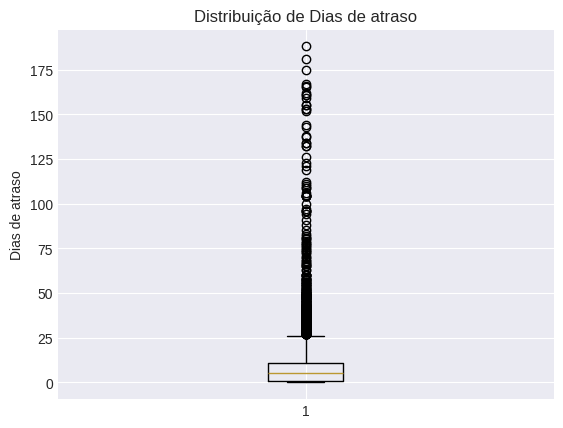

In [ ]:
# Calcular se houve atraso na entrega
orders['delivery_delay']  = (
    orders['order_delivered_customer_date'] > orders['order_estimated_delivery_date']
).astype(int)

print(f"Distribuição de atrasos:")
print(orders['delivery_delay'].value_counts())
print(f"\nPercentual de atrasos:{orders['delivery_delay'].mean()*100:.2f}")

orders['days_late'] = (
    orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']
).dt.days

orders['days_late']= orders['days_late'].fillna(0)

print(f"\nEstatística de dias de atraso:")
print(orders[orders['delivery_delay']==1]['days_late'].describe())
late_orders = orders[orders['delivery_delay']==1]['days_late']
plt.figure()
plt.boxplot(late_orders)
plt.title('Distribuição de Dias de atraso')
plt.ylabel('Dias de atraso')
plt.show()


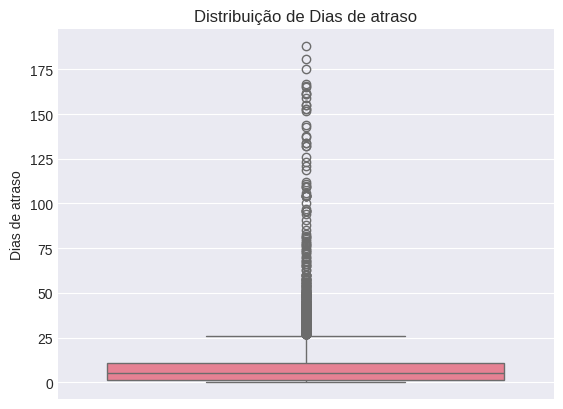

In [ ]:
plt.figure()
sns.boxplot(y=orders[orders['delivery_delay']==1]['days_late'])
plt.title('Distribuição de Dias de atraso')
plt.ylabel('Dias de atraso')
plt.show()


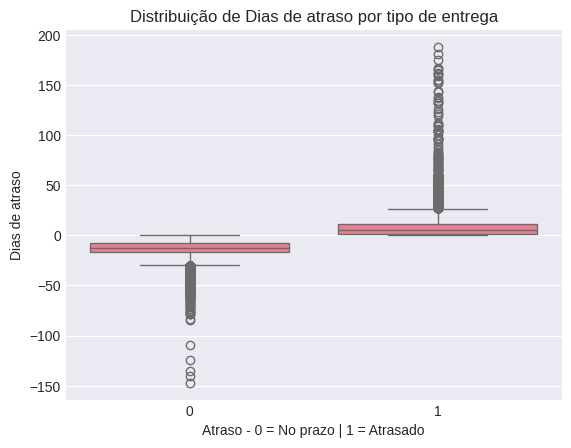

In [ ]:
plt.figure()
sns.boxplot(x='delivery_delay', y='days_late', data=orders)
plt.title('Distribuição de Dias de atraso por tipo de entrega')
plt.ylabel('Dias de atraso')
plt.xlabel('Atraso - 0 = No prazo | 1 = Atrasado')
plt.show()

**Classificação com PySpark**

Instalando dependencias para criação de modelo e produto de dados com pyspark

In [ ]:
!pip install -q pyspark findspark kagglehub ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.3 MB/s eta 0:00:00


In [ ]:
import os
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = (SparkSession.builder
    .appName('OlistSparkML')
    .config('spark.driver.memory', '4g')
    .config('spark.sql.repl.eagerEval.enabled', True)
    .getOrCreate())

print(f'✓ Spark {spark.version} iniciado com sucesso!')

✓ Spark 4.0.2 iniciado com sucesso!


In [ ]:
#Baixando os dados do kaggle - olistbr
import kagglehub
import glob

print('Baixando dataset do Kaggle...')
path = kagglehub.dataset_download('olistbr/brazilian-ecommerce')
print(f'Dataset baixado em: {path}')

# Carregar arquivos CSV
data_files = {}
for f in glob.glob(path + '/*.csv'):
    name = os.path.basename(f).replace('.csv', '')
    data_files[name] = spark.read.csv(f, header=True, inferSchema=True, multiLine=True, escape='"')
    print(f'✓ {name}: {data_files[name].count()} linhas')

Baixando dataset do Kaggle...
Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Dataset baixado em: /kaggle/input/brazilian-ecommerce
✓ olist_customers_dataset: 99441 linhas
✓ olist_sellers_dataset: 3095 linhas
✓ olist_order_reviews_dataset: 99224 linhas
✓ olist_order_items_dataset: 112650 linhas
✓ olist_products_dataset: 32951 linhas
✓ olist_geolocation_dataset: 1000163 linhas
✓ product_category_name_translation: 71 linhas
✓ olist_orders_dataset: 99441 linhas
✓ olist_order_payments_dataset: 103886 linhas


In [ ]:
from pyspark.sql.functions import col, to_timestamp, datediff

orders = data_files['olist_orders_dataset']
customers = data_files['olist_customers_dataset']
items = data_files['olist_order_items_dataset']

# Converter datas
orders = (orders
    .withColumn('order_purchase_timestamp', to_timestamp(col('order_purchase_timestamp')))
    .withColumn('order_delivered_customer_date', to_timestamp(col('order_delivered_customer_date')))
    .withColumn('order_estimated_delivery_date', to_timestamp(col('order_estimated_delivery_date')))
    .withColumn('delivery_delay', (col('order_delivered_customer_date') > col('order_estimated_delivery_date')).cast('integer'))
    .withColumn('processing_time_days', datediff(col('order_delivered_customer_date'), col('order_purchase_timestamp'))))

# Sumarizar itens
items_summary = (items.groupBy('order_id')
    .agg({'order_item_id': 'count', 'price': 'sum', 'freight_value': 'sum'})
    .withColumnRenamed('count(order_item_id)', 'num_items')
    .withColumnRenamed('sum(price)', 'total_price')
    .withColumnRenamed('sum(freight_value)', 'total_freight'))

# Juntar dados
df_full = (orders.join(customers, 'customer_id')
    .join(items_summary, 'order_id')
    .select('order_id', 'customer_state', 'delivery_delay', 'processing_time_days', 'num_items', 'total_price', 'total_freight'))

df_full = df_full.dropna()
print(f'Dataset final: {df_full.count()} pedidos')
df_full.show(5)

Dataset final: 96476 pedidos
+--------------------+--------------+--------------+--------------------+---------+-----------+-------------+
|            order_id|customer_state|delivery_delay|processing_time_days|num_items|total_price|total_freight|
+--------------------+--------------+--------------+--------------------+---------+-----------+-------------+
|e481f51cbdc54678b...|            SP|             0|                   8|        1|      29.99|         8.72|
|53cdb2fc8bc7dce0b...|            BA|             0|                  14|        1|      118.7|        22.76|
|47770eb9100c2d0c4...|            GO|             0|                   9|        1|      159.9|        19.22|
|949d5b44dbf5de918...|            RN|             0|                  14|        1|       45.0|         27.2|
|ad21c59c0840e6cb8...|            SP|             0|                   3|        1|       19.9|         8.72|
+--------------------+--------------+--------------+--------------------+---------+--------

In [ ]:
# Analisar a distribuição dos atrasos e os estados com mais atrasos
print("\n *** Distribuição dos atrasos dos pedidos ***")
df_full.groupBy('delivery_delay').count().show()

print("\n *** Top 10 de Estados com mais atrasos ***")
(df_full.groupBy('customer_state')
    .agg({'delivery_delay': 'avg'})
    .withColumnRenamed('avg(delivery_delay)', 'taxa_atraso')
    .orderBy(col('taxa_atraso').desc())
    .show(10))


 *** Distribuição dos atrasos dos pedidos ***
+--------------+-----+
|delivery_delay|count|
+--------------+-----+
|             1| 7827|
|             0|88649|
+--------------+-----+


 *** Top 10 de Estados com mais atrasos ***
+--------------+-------------------+
|customer_state|        taxa_atraso|
+--------------+-------------------+
|            AL|0.23929471032745592|
|            MA|0.19665271966527198|
|            PI|0.15966386554621848|
|            CE| 0.1532447224394058|
|            SE|0.15223880597014924|
|            BA|0.14035626535626536|
|            RJ|0.13470412045656927|
|            TO|0.12773722627737227|
|            PA|0.12367864693446089|
|            ES|0.12230576441102757|
+--------------+-------------------+
only showing top 10 rows


**Criar pipeline de classificação**

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

train_data, test_data = df_full.randomSplit([0.8, 0.2], seed=42)
print(f'Treino: {train_data.count()} | Teste: {test_data.count()}')

state_indexer = StringIndexer(inputCol='customer_state', outputCol='state_indexed', handleInvalid='keep')
feature_cols = ['state_indexed', 'processing_time_days', 'num_items', 'total_price', 'total_freight']
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol='features_raw')
scaler = StandardScaler(inputCol='features_raw', outputCol='features')
rf = RandomForestClassifier(labelCol='delivery_delay', featuresCol='features', seed=42)
pipeline = Pipeline(stages=[state_indexer, vector_assembler, scaler, rf])
print('\n Pipeline Criada com sucesso!!!')



Treino: 77077 | Teste: 19399

 Pipeline Criada com sucesso!!!


In [ ]:
print('Treinando modelo...')
pipeline_model = pipeline.fit(train_data)

print('Avaliando modelo...')
predictions = pipeline_model.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol='delivery_delay', metricName='areaUnderROC')
roc_auc = evaluator.evaluate(predictions)
print(f'\nAUC-ROC: {roc_auc:.4f}')

print('\nMatriz de Confusão:')
predictions.groupBy('delivery_delay', 'prediction').count().show()

Treinando modelo...
Avaliando modelo...

AUC-ROC: 0.9334

Matriz de Confusão:
+--------------+----------+-----+
|delivery_delay|prediction|count|
+--------------+----------+-----+
|             1|       0.0|  620|
|             0|       0.0|17625|
|             1|       1.0|  926|
|             0|       1.0|  228|
+--------------+----------+-----+



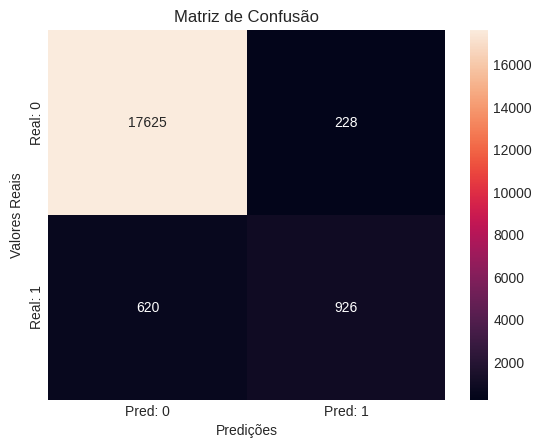

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Converter dados para pandas
confusion_df = (
    predictions
    .groupBy('delivery_delay', 'prediction')
    .count()
    .toPandas()

)

#criar uma matriz em branco manualmente
matrix =[[0,0], [0,0]]

#inserir dados na matriz
for _, row in confusion_df.iterrows():
    real = int(row['delivery_delay'])
    pred = int(row['prediction'])
    matrix[real][pred] = int(row['count'])

cm = pd.DataFrame(matrix, index=['Real: 0', 'Real: 1'], columns=['Pred: 0', 'Pred: 1']).astype(int)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Matriz de Confusão')
plt.xlabel('Predições')
plt.ylabel('Valores Reais')
plt.show()




In [ ]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier
import pandas as pd

models = {
    'Logistic Regression': LogisticRegression(labelCol='delivery_delay'),
    'Decision Tree': DecisionTreeClassifier(labelCol='delivery_delay'),
    'Random Forest': RandomForestClassifier(labelCol='delivery_delay'),
    'Gradient Boosting': GBTClassifier(labelCol='delivery_delay')
}

results = {}
for name, model in models.items():
    print(f'Treinando {name}...')
    temp_pipeline = Pipeline(stages=[state_indexer, vector_assembler, scaler, model])
    temp_model = temp_pipeline.fit(train_data)
    temp_predictions = temp_model.transform(test_data)
    roc_auc = evaluator.evaluate(temp_predictions)
    results[name] = roc_auc
    print(f'  AUC: {roc_auc:.4f}')

results_df = pd.DataFrame(list(results.items()), columns=['Modelo', 'AUC']).sort_values('AUC', ascending=False)
print('\nComparação de Modelos:')
print(results_df.to_string(index=False))

Treinando Logistic Regression...
  AUC: 0.9371
Treinando Decision Tree...
  AUC: 0.5475
Treinando Random Forest...
  AUC: 0.9342
Treinando Gradient Boosting...
  AUC: 0.9546

Comparação de Modelos:
             Modelo      AUC
  Gradient Boosting 0.954644
Logistic Regression 0.937072
      Random Forest 0.934164
      Decision Tree 0.547462


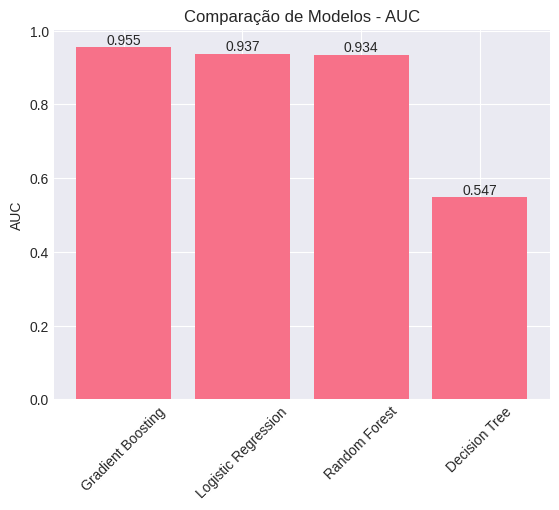

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
bars = plt.bar(results_df['Modelo'], results_df['AUC'])

plt.xticks(rotation=45)
plt.ylabel('AUC')
plt.title('Comparação de Modelos - AUC')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:.3f}',
             ha='center', va='bottom')
plt.show()

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
    .addGrid(rf.numTrees, [20, 50])
    .addGrid(rf.maxDepth, [5, 10])
    .build())
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='delivery_delay'),
                          numFolds=5)
print("Executando Cross-validation")
cv_model = crossval.fit(train_data)

best_pipeline_model = cv_model.bestModel
best_rf_model = best_pipeline_model.stages[-1]

print('\nMelhor modelo encontrado!')
print(f'Número de Árvores: {best_rf_model.getNumTrees}')
print(f'Profundidade Máxima: {best_rf_model.getMaxDepth}')
# Para salvar best_pipeline_model.write().overwrite().save("diretório/pasta")
#Para abrir modelo salvo
# from pyspark.ml import PipelineModel
# modelo =PipelineModel.load("pasta/modelosalvo")


Executando Cross-validation

Melhor modelo encontrado!
Número de Árvores: 50
Profundidade Máxima: <bound method _DecisionTreeParams.getMaxDepth of RandomForestClassificationModel: uid=RandomForestClassifier_6f9f2a2dbb6b, numTrees=50, numClasses=2, numFeatures=5>


In [ ]:
# Salvando meu modelo
model_path = "/content/best_rf_model"

best_rf_model.write().overwrite().save(model_path)

In [ ]:
# Para usar vamos compactar o modelo usando o shutil
import shutil

shutil.make_archive("best_rf_model", 'zip', model_path)


'/content/best_rf_model.zip'

Criando uma aplicação interativa para predição usando o modelo


In [ ]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

states = [row.customer_state for row in df_full.select('customer_state').distinct().collect()]

state_widget = widgets.Dropdown(options=sorted(states), description='Estado:')
price_widget = widgets.FloatSlider(value=150, min=10, max=5000, step=10, description='Preço:')
freight_widget = widgets.FloatSlider(value=25, min=5, max=400, step=5, description='Frete:')
items_widget = widgets.IntSlider(value=1, min=1, max=20, description='Itens:')
processing_widget = widgets.IntSlider(value=3, min=1, max=30, description='Proc:')
predict_button = widgets.Button(description='Prever', button_style='success')
output_widget = widgets.Output()

def predict_delay(b):
    with output_widget:
        output_widget.clear_output()
        input_data = pd.DataFrame([{
            'customer_state': state_widget.value,
            'processing_time_days': processing_widget.value,
            'num_items': items_widget.value,
            'total_price': price_widget.value,
            'total_freight': freight_widget.value
        }])
        input_df = spark.createDataFrame(input_data)
        prediction_result = best_pipeline_model.transform(input_df)
        prob = prediction_result.select('probability').first()[0][1]
        if prob > 0.5:
            print(f'🚨 ALERTA: {prob*100:.2f}% chance de atraso')
        else:
            print(f'✅ OK: {prob*100:.2f}% chance de atraso')

predict_button.on_click(predict_delay)

ui = widgets.VBox([
    widgets.HBox([state_widget, items_widget]),
    widgets.HBox([price_widget, freight_widget]),
    widgets.HBox([processing_widget]),
    predict_button,
    output_widget
])

print('Use os controles abaixo:')
display(ui)

Use os controles abaixo:


PRevisão de vendas por produto e estado

In [ ]:
import kagglehub
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import ipywidgets as widgets
from IPython.display import display

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
print('Baixando dataset do Kaggle...')
path = kagglehub.dataset_download('olistbr/brazilian-ecommerce')
print(f'Dataset baixado em: {path}')

data_files = {}
for f in glob.glob(path + '/*.csv'):
    name = os.path.basename(f).replace('.csv', '')
    data_files[name] = pd.read_csv(f)
    print(f'✓ {name} carregado.')

Baixando dataset do Kaggle...
Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Dataset baixado em: /kaggle/input/brazilian-ecommerce
✓ olist_customers_dataset carregado.
✓ olist_sellers_dataset carregado.
✓ olist_order_reviews_dataset carregado.
✓ olist_order_items_dataset carregado.
✓ olist_products_dataset carregado.
✓ olist_geolocation_dataset carregado.
✓ product_category_name_translation carregado.
✓ olist_orders_dataset carregado.
✓ olist_order_payments_dataset carregado.


In [ ]:
# Merge dos dataframes necessários
orders = data_files['olist_orders_dataset']
items = data_files['olist_order_items_dataset']
products = data_files['olist_products_dataset']
customers = data_files['olist_customers_dataset']
translations = data_files['product_category_name_translation']

df = orders.merge(items, on='order_id')\
           .merge(products, on='product_id')\
           .merge(customers, on='customer_id')\
           .merge(translations, on='product_category_name')

# Converter e extrair features de data
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['year'] = df['order_purchase_timestamp'].dt.year
df['month'] = df['order_purchase_timestamp'].dt.month
df['day_of_week'] = df['order_purchase_timestamp'].dt.dayofweek

# Filtrar colunas relevantes
df_sales = df[['order_purchase_timestamp', 'year', 'month', 'customer_state', 'product_category_name_english', 'price']]
df_sales = df_sales.rename(columns={'product_category_name_english': 'category', 'customer_state': 'state'})

print('Dataset de vendas criado com sucesso!')
df_sales.head()

Dataset de vendas criado com sucesso!


,order_purchase_timestamp,year,month,state,category,price
0,2017-10-02 10:56:33,2017,10,SP,housewares,29.99
1,2018-07-24 20:41:37,2018,7,BA,perfumery,118.70
2,2018-08-08 08:38:49,2018,8,GO,auto,159.90
3,2017-11-18 19:28:06,2017,11,RN,pet_shop,45.00
4,2018-02-13 21:18:39,2018,2,SP,stationery,19.90


Top 10 Categorias por Vendas:
category
health_beauty            1258681.34
watches_gifts            1205005.68
bed_bath_table           1036988.68
sports_leisure            988048.97
computers_accessories     911954.32
furniture_decor           729762.49
cool_stuff                635290.85
housewares                632248.66
auto                      592720.11
garden_tools              485256.46
Name: total_sales, dtype: float64


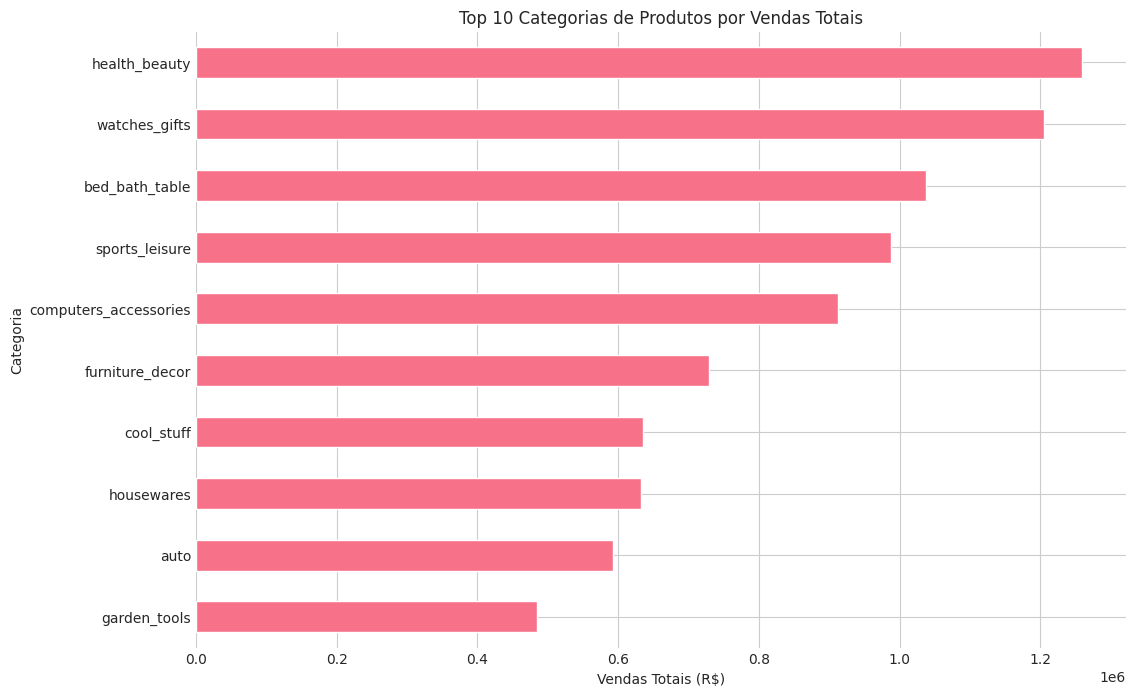

In [ ]:
# Agrupar vendas mensais por categoria e estado
sales_agg = df_sales.groupby(['year', 'month', 'state', 'category']).agg(total_sales=('price', 'sum')).reset_index()

print('Top 10 Categorias por Vendas:')
top_categories = sales_agg.groupby('category')['total_sales'].sum().nlargest(10)
print(top_categories)

plt.figure(figsize=(12, 8))
top_categories.sort_values().plot(kind='barh')
plt.title('Top 10 Categorias de Produtos por Vendas Totais')
plt.xlabel('Vendas Totais (R$)')
plt.ylabel('Categoria')
plt.show()

In [ ]:
# Modelagem e previão de vendas
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Usar o dataframe agregado para modelagem
df_model = sales_agg.copy()

# Features e Target
X = df_model[['year', 'month', 'state', 'category']]
y = df_model['total_sales']

# Preprocessing para variáveis categóricas
categorical_features = ['state', 'category']
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', one_hot_encoder, categorical_features)],
    remainder='passthrough')

# Criar o pipeline de modelagem
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo
model.fit(X_train, y_train)

# Avaliar o modelo
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'Modelo treinado com sucesso! R² Score: {r2:.2f}')

Modelo treinado com sucesso! R² Score: 0.35


**Exercicio**: Refazer a predição, usando pyspark, porém fazendo crossvalidation e testando mais modelos, com mais dados, o objetivo é ficar o r2 acima dos 0.65

In [ ]:
# Listas para os dropdowns
unique_states = sorted(sales_agg['state'].unique())
unique_categories = sorted(sales_agg['category'].unique())

# Widgets
state_widget = widgets.Dropdown(options=unique_states, description='Estado:')
category_widget = widgets.Dropdown(options=unique_categories, description='Categoria:')
predict_button = widgets.Button(description='Fazer Previsão', button_style='success')
output_widget = widgets.Output()

def on_predict_button_clicked(b):
    with output_widget:
        output_widget.clear_output()
        state = state_widget.value
        category = category_widget.value

        # Criar dataframe para o próximo mês
        last_date = df_sales['order_purchase_timestamp'].max()
        next_month_date = last_date + pd.DateOffset(months=1)
        future_df = pd.DataFrame([{
            'year': next_month_date.year,
            'month': next_month_date.month,
            'state': state,
            'category': category
        }])

        # Fazer a previsão
        predicted_sales = model.predict(future_df)[0]
        print(f'--- Previsão para {category} em {state} ---')
        print(f'Vendas estimadas para o próximo mês: R$ {predicted_sales:,.2f}')

        # Plotar histórico e previsão
        history = sales_agg[(sales_agg['state'] == state) & (sales_agg['category'] == category)]
        history['date'] = pd.to_datetime(history['year'].astype(str) + '-' + history['month'].astype(str) + '-01')

        plt.figure(figsize=(14, 7))
        plt.plot(history['date'], history['total_sales'], marker='o', linestyle='-', label='Vendas Históricas')
        plt.scatter([next_month_date], [predicted_sales], color='red', s=100, zorder=5, label=f'Previsão (R$ {predicted_sales:,.2f})')
        plt.title(f'Histórico e Previsão de Vendas para {category} em {state}')
        plt.xlabel('Data')
        plt.ylabel('Vendas Totais (R$)')
        plt.legend()
        plt.grid(True)
        plt.show()

predict_button.on_click(on_predict_button_clicked)

# Exibir a interface
print('Selecione um estado e uma categoria para prever as vendas do próximo mês.')
display(widgets.VBox([state_widget, category_widget, predict_button, output_widget]))

Selecione um estado e uma categoria para prever as vendas do próximo mês.


Exercicio: Refazer a predição, usando pyspark, porém fazendo crossvalidation e testando mais modelos, com mais dados, o objetivo é ficar o r2 acima dos 0.65

In [ ]:
# ===============================
# PREVISÃO DE VENDAS COM PYSPARK
# ===============================

from pyspark.sql.functions import col, year, month, sum as spark_sum
from pyspark.sql.types import StringType # Import StringType for explicit casting
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# ===============================
# CRIAR DATASET EM PYSPARK
# ===============================

# Re-carregar os arquivos CSV como PySpark DataFrames para garantir o tipo correto
import kagglehub
import glob
import os

print('Recarregando dataset do Kaggle como PySpark DataFrames...')
path = kagglehub.dataset_download('olistbr/brazilian-ecommerce')
pyspark_data_files = {}
for f in glob.glob(path + '/*.csv'):
    name = os.path.basename(f).replace('.csv', '')
    pyspark_data_files[name] = spark.read.csv(f, header=True, inferSchema=True, multiLine=True, escape='"')
    print(f'✓ {name}: {pyspark_data_files[name].count()} linhas (PySpark)')

orders_sp = pyspark_data_files['olist_orders_dataset']
items_sp = pyspark_data_files['olist_order_items_dataset']
products_sp = pyspark_data_files['olist_products_dataset']
customers_sp = pyspark_data_files['olist_customers_dataset']
translations_sp = pyspark_data_files['product_category_name_translation']

# Explicitly cast join keys to StringType to ensure consistency
orders_sp = orders_sp.withColumn("order_id", col("order_id").cast(StringType()))
items_sp = items_sp.withColumn("order_id", col("order_id").cast(StringType()))
products_sp = products_sp.withColumn("product_id", col("product_id").cast(StringType()))
customers_sp = customers_sp.withColumn("customer_id", col("customer_id").cast(StringType()))
translations_sp = translations_sp.withColumn("product_category_name", col("product_category_name").cast(StringType()))

# Join completo
df_sales_sp = (orders_sp
    .join(items_sp, 'order_id')\
           .join(products_sp, 'product_id')\
           .join(customers_sp, 'customer_id')\
           .join(translations_sp, 'product_category_name')
)

# Converter datas e criar features temporais
from pyspark.sql.functions import to_timestamp

df_sales_sp = df_sales_sp.withColumn(
    'order_purchase_timestamp',
    to_timestamp(col('order_purchase_timestamp'))
)

df_sales_sp = (df_sales_sp
    .withColumn('year', year(col('order_purchase_timestamp')))
    .withColumn('month', month(col('order_purchase_timestamp')))
    # Removed 'day_of_week' from here as it's not used in sales_agg_sp
)

# Agrupar vendas
sales_agg_sp = (df_sales_sp
    .groupBy('year', 'month', 'customer_state', 'product_category_name_english')
    .agg(
        spark_sum('price').alias('total_sales'),
        spark_sum('freight_value').alias('total_freight'),
        spark_sum('order_item_id').alias('total_items')
    )
    .dropna()
)

print(f"Dataset final: {sales_agg_sp.count()} registros")

# ===============================
# FEATURE ENGINEERING
# ===============================

# Indexadores
state_indexer = StringIndexer(
    inputCol='customer_state',
    outputCol='state_index',
    handleInvalid='keep'
)

category_indexer = StringIndexer(
    inputCol='product_category_name_english',
    outputCol='category_index',
    handleInvalid='keep'
)

encoder = OneHotEncoder(
    inputCols=['state_index', 'category_index'],
    outputCols=['state_vec', 'category_vec']
)

feature_cols = [
    'state_vec',
    'category_vec',
    'year',
    'month',
    # Removed 'day_of_week' from feature_cols
    'total_freight',
    'total_items'
]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features_raw'
)

scaler = StandardScaler(
    inputCol='features_raw',
    outputCol='features'
)

# ===============================
# SPLIT TREINO / TESTE
# ===============================

train_data, test_data = sales_agg_sp.randomSplit([0.8, 0.2], seed=42)

# ===============================
# MODELOS DE REGRESSÃO
# ===============================

rf = RandomForestRegressor(
    labelCol='total_sales',
    featuresCol='features',
    seed=42
)

gbt = GBTRegressor(
    labelCol='total_sales',
    featuresCol='features',
    seed=42
)

lr = LinearRegression(
    labelCol='total_sales',
    featuresCol='features'
)

models = {
    "Random Forest": rf,
    "Gradient Boosted Trees": gbt,
    "Linear Regression": lr
}

# Avaliador
evaluator = RegressionEvaluator(
    labelCol='total_sales',
    predictionCol='prediction',
    metricName='r2'
)

results = {}

# ===============================
# TREINAR + CROSS VALIDATION
# ===============================

for name, model in models.items():

    print(f"\nTreinando modelo: {name}")

    pipeline = Pipeline(stages=[
        state_indexer,
        category_indexer,
        encoder,
        assembler,
        scaler,
        model
    ])

    # Grid de hiperparâmetros
    if name == "Random Forest":
        paramGrid = (ParamGridBuilder()
            .addGrid(model.numTrees, [50, 100])
            .addGrid(model.maxDepth, [5, 10])
            .build())

    elif name == "Gradient Boosted Trees":
        paramGrid = (ParamGridBuilder()
            .addGrid(model.maxDepth, [5, 8])
            .addGrid(model.maxIter, [20, 50])
            .build())

    else:
        paramGrid = (ParamGridBuilder()
            .addGrid(model.regParam, [0.0, 0.1, 0.5])
            .build())

    crossval = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        numFolds=5,
        parallelism=2
    )

    cv_model = crossval.fit(train_data)

    predictions = cv_model.transform(test_data)

    r2 = evaluator.evaluate(predictions)

    results[name] = (r2, cv_model)

    print(f"R² = {r2:.4f}")

# ===============================
# COMPARAÇÃO FINAL
# ===============================

best_model_name = max(results, key=lambda x: results[x][0])
best_r2 = results[best_model_name][0]
best_model = results[best_model_name][1]

print("\n==========================")
print(" MELHOR MODELO ENCONTRADO")
print("==========================")
print(f"Modelo: {best_model_name}")
print(f"R²: {best_r2:.4f}")

# ===============================
# SALVAR MODELO
# ===============================

best_model.bestModel.write().overwrite().save("best_sales_model_pyspark")

Recarregando dataset do Kaggle como PySpark DataFrames...
Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
✓ olist_customers_dataset: 99441 linhas (PySpark)
✓ olist_sellers_dataset: 3095 linhas (PySpark)
✓ olist_order_reviews_dataset: 99224 linhas (PySpark)
✓ olist_order_items_dataset: 112650 linhas (PySpark)
✓ olist_products_dataset: 32951 linhas (PySpark)
✓ olist_geolocation_dataset: 1000163 linhas (PySpark)
✓ product_category_name_translation: 71 linhas (PySpark)
✓ olist_orders_dataset: 99441 linhas (PySpark)
✓ olist_order_payments_dataset: 103886 linhas (PySpark)
Dataset final: 11537 registros

Treinando modelo: Random Forest
R² = 0.8768

Treinando modelo: Gradient Boosted Trees
R² = 0.8566

Treinando modelo: Linear Regression
R² = 0.8626

 MELHOR MODELO ENCONTRADO
Modelo: Random Forest
R²: 0.8768
